In [1]:
import copy
from trueskill import Rating, quality_1vs1, rate_1vs1
import numpy as np
import itertools
from sklearn.utils import resample
import random
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# TrueSkill

Since the performance of some systems may be very similar and a total ordering would not reflect this, we adopt the practice used in machine translation of presenting a partial ordering into significance clusters established by bootstrap resampling. The TrueSkill algorithm is run 200 times, producing slightly different rankings each time as pairs of system outputs for comparison are randomly sampled. This way we can determine the range of ranks where each system is placed 95% of the time or more often. Clusters are then formed of systems whose rank ranges overlap.

In [2]:
def get_records(filename):
    """
    Get records from a particular Excel file.
    """
    df = pd.read_excel(filename)
    return df.to_dict('records')


def get_best_worst(record):
    """
    Get the best and the worst option
    """
    best_options = ["Answer.best_coh", "Answer.best_grammar", "Answer.best_redun"]
    worst_options = ["Answer.worst_coh", "Answer.worst_grammar", "Answer.worst_redun"]
    for option in best_options:
        if option in record:
            best = record[option]
            break
    for option in worst_options:
        if option in record:
            worst = record[option]
            break
    return best, worst


def winnerloser(record):
    """
    Determine which system is the best and which is the worst.
    """
    systemdict = {'sys0': 'Gold', 'sys1': 'Template', 'sys2': 'ED+CC', 'sys3': 'Hier', 'sys4': 'Macro'}

    system_a = systemdict[record['Input.system1']]
    system_b = systemdict[record['Input.system2']]

    best, worst = get_best_worst(record)
    
    if (best == 'A') and (worst == 'B'):
        outcomedict = {'best': system_a, 'worst': system_b}
    elif (best == 'B') and (worst == 'A'):
        outcomedict = {'best': system_b, 'worst': system_a}
    else:
        outcomedict = 'error'

    return outcomedict


def is_overlapping(x1,x2,y1,y2):
    return max(x1,y1) <= min(x2,y2)


def trueskill_scores(recordlist):
    # Defining number of iterations for bootstrap resample
    n_iterations = 1000

    bootstrapscores = {'Gold': [], 'Template': [], 'ED+CC': [], 'Hier': [], 'Macro': []}

    random.seed(42069)
    seedlist = random.sample(range(1000000000), 1000)

    # Each loop iteration is a single bootstrap resample and model fit
    for i in range(n_iterations):
        #print(i)
        # All the systems used in this experiment, we're going to start them off with no rating.
        iterationratescoredict = {'Gold': Rating(), 'Template': Rating(), 'ED+CC': Rating(), 'Hier': Rating(), 'Macro': Rating()}
        # Sampling n_samples from data, with replacement
        bootstrap_sample = resample(recordlist, replace=True, n_samples=len(recordlist), random_state=seedlist[i])

        #Update the rating for the systems based on the best and worst system for each record
        for record in bootstrap_sample:
            windict = winnerloser(record)
            if windict != 'error':
                iterationratescoredict[windict['best']], iterationratescoredict[windict['worst']] = rate_1vs1(iterationratescoredict[windict['best']], iterationratescoredict[windict['worst']])

        #And add the final scores of each iteration to the bootstrapscores dict
        for iterationsystem in iterationratescoredict:
            bootstrapscores[iterationsystem].append(iterationratescoredict[iterationsystem])

    #Trueskill rating contains two values: mu (the actual score) and sigma (the certainty of the score). We only use mu for our calculations.
    newbootstrapscores = copy.deepcopy(bootstrapscores)
    for key in newbootstrapscores:
        newbootstrapscores[key] = [x.mu for x in newbootstrapscores[key]]

    #Calculate the confidence intervals
    intervaldict = {}
    for key in newbootstrapscores:
        intervaldict.update({key: list(np.percentile(newbootstrapscores[key], [2.5, 97.5]))})

    print(intervaldict)

    # Now, we'll make clusters as discussed in the original paper.
    allclusters = []
    for system in intervaldict:
        clusterlist = [system]
        # We compare each system to the other systems in the intervaldict
        for compare in intervaldict:
            if system == compare:
                continue
            # If the two intervals overlap, make a cluster
            if is_overlapping(intervaldict[system][0], intervaldict[system][1], intervaldict[compare][0],
                              intervaldict[compare][1]):
                clusterlist.append(compare)

        #Check if the cluster did not exist before
        sortedcluster = sorted(clusterlist)
        if sortedcluster not in allclusters:
            allclusters.append(sortedcluster)

    print(allclusters)

    #The clusters seem to be lacking explicit information. I want to know which systems do not have overlapping intervals. So if pairs have non-overlapping intervals, we mark them here.
    pairwise_comparisons = list(itertools.combinations(intervaldict.keys(), 2))
    for combi in pairwise_comparisons:
        if not is_overlapping(intervaldict[combi[0]][0], intervaldict[combi[0]][1], intervaldict[combi[1]][0], intervaldict[combi[1]][1]):
            print(combi[0] + ' differs from ' + combi[1])
    return intervaldict

In [3]:
repetitionlist = get_records("./Responses/Combined/Repetition.xlsx")
coherencelist = get_records("./Responses/Combined/Coherence.xlsx")
grammaticalitylist = get_records("./Responses/Combined/Grammaticality.xlsx")

In [4]:
print('Repetition:')
rep_intervals = trueskill_scores(repetitionlist)

print('Coherence:')
coh_intervals = trueskill_scores(coherencelist)

print('Grammaticality:')
gram_intervals = trueskill_scores(grammaticalitylist)

Repetition:
{'Gold': [22.770965301503075, 26.84453193987333], 'Template': [25.96703151128763, 30.07875691733249], 'ED+CC': [21.089463851049256, 25.348114947688103], 'Hier': [21.92499772248315, 26.09568760859535], 'Macro': [22.733064359213778, 26.73274073074079]}
[['ED+CC', 'Gold', 'Hier', 'Macro', 'Template'], ['Gold', 'Hier', 'Macro', 'Template'], ['ED+CC', 'Gold', 'Hier', 'Macro']]
Template differs from ED+CC
Coherence:
{'Gold': [22.770360883996045, 27.254677098232495], 'Template': [24.525273310565286, 28.75592245814999], 'ED+CC': [21.790577078225205, 26.235840080643], 'Hier': [22.09925834985412, 26.396984241096938], 'Macro': [22.97474867827888, 27.17695494258322]}
[['ED+CC', 'Gold', 'Hier', 'Macro', 'Template']]
Grammaticality:
{'Gold': [23.416799429960065, 27.850067362567998], 'Template': [23.884949173782534, 28.445182460260416], 'ED+CC': [21.49176497319727, 25.960779037337815], 'Hier': [22.26562776976902, 26.581431964576343], 'Macro': [22.98039843743289, 27.39835414804036]}
[['ED+

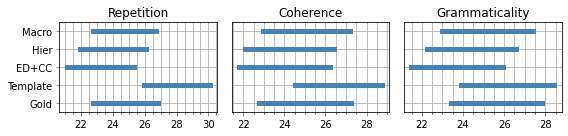

In [5]:
import matplotlib.ticker as tck

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(8)
fig.set_figheight(2)

def get_lines(intervals):
    "Create lines to plot."
    lines = []
    systems = ['Gold', 'Template', 'ED+CC', 'Hier', 'Macro']
    for i, sys in enumerate(systems, start=1):
        x1, x2 = intervals[sys]
        line = [(i,x1),(i,x2)]
        lines.append(line)
    return lines

def plot_lines(ax,lines):
    "Plot lines in the ax."
    for line in lines:
        (y1,x1),(y2,x2) = line
        ax.plot([x1,x2],[y1,y2], linewidth=5.0, color='steelblue')

def modify_ax(ax, title):
    "Change appearance"
    ax.set_title(title)
    ax.set_ylim(ymin=0.5,ymax=5.5)
    # ax.set_xlim(xmin=20, xmax=32)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.grid(which = 'minor')
    ax.axes.get_yaxis().set_visible(False)        

systems = ['Gold', 'Template', 'ED+CC', 'Hier', 'Macro']

########################################################
# Plot rep:

lines = get_lines(rep_intervals)
plot_lines(ax1, lines)
modify_ax(ax1, "Repetition")

# Add system info:
ax1.axes.get_yaxis().set_visible(True)   
ticks = ax1.get_yticks()
ax1.set_yticks([1,2,3,4,5], systems)
ax1.tick_params(color='gray')

########################################################
# Plot coh:

lines = get_lines(coh_intervals)
plot_lines(ax2, lines)
modify_ax(ax2, "Coherence")

# Modify ticks
ax2.axes.get_yaxis().set_visible(True)
ax2.set_yticks([1,2,3,4,5],['']*5)
ax2.tick_params(axis='y',length=0)
ax2.tick_params(color='gray')

########################################################
# Plot gram:

lines = get_lines(gram_intervals)
plot_lines(ax3, lines)
modify_ax(ax3, "Grammaticality")

# Modify ticks
ax3.axes.get_yaxis().set_visible(True)
ax3.set_yticks([1,2,3,4,5],['']*5)
ax3.tick_params(axis='y',length=0)
ax3.tick_params(color='gray')

plt.tight_layout()
plt.savefig("./Figures/TrueSkill.pdf",bbox_inches="tight")